In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
def data_preprocessing_multiclass(path):
    from sklearn.model_selection import train_test_split
    df = pd.read_csv(path)

    # Selecting features
    select_features_df = df[['AckDat', 'sHops', 'Seq', 'TcpRtt', 'dMeanPktSz', 'Offset', 'sTtl', 'Mean', 'SrcTCPBase', 'sMeanPktSz', 'DstLoss', 'Loss', 'dTtl', 'SrcBytes', 'TotBytes']]
    select_features_df['sHops'].fillna(df['sHops'].mean(), inplace=True)
    select_features_df['sTtl'].fillna(df['sTtl'].mean(), inplace=True)
    select_features_df['SrcTCPBase'].fillna(df['SrcTCPBase'].mean(), inplace=True)
    select_features_df['dTtl'].fillna(df['dTtl'].mean(), inplace=True)

    # Extracting target variable
    df_output = df['Attack Type']

   # Label encoding target variable
    label_encoder = LabelEncoder()
    df_output_encoded = label_encoder.fit_transform(df_output)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(select_features_df, df_output_encoded, test_size=0.2, random_state=42)

    # Standardizing input features
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train)
    X_test_standardized = scaler.transform(X_test)

    # Reshape input data for LSTM
    X_train_reshaped = X_train_standardized.reshape(X_train_standardized.shape[0], 1, X_train_standardized.shape[1])
    X_test_reshaped = X_test_standardized.reshape(X_test_standardized.shape[0], 1, X_test_standardized.shape[1])

    return X_train_reshaped, X_test_reshaped, y_train, y_test, label_encoder


In [3]:
#Execution of the Multiclass RNN model...
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

# Load and preprocess the data
data_path = '/content/drive/MyDrive/5G NIDD/Combined.csv'  # Update with your file path

# Preprocess data
X_train, X_test, y_train, y_test, label_encoder = data_preprocessing_multiclass(data_path)

# Print the shape of X_train
print(X_train.shape)



(972712, 1, 15)


In [4]:
# Define the RNN multiclass model
def create_multiclass_rnn(input_shape, num_classes):
    model = Sequential([
        LSTM(units=64, input_shape=input_shape),
        Dense(num_classes, activation='softmax')
    ])
    return model
# Print the shape of X_train
print(X_train.shape)

(972712, 1, 15)


In [5]:

# Determine the number of unique classes
num_classes = len(np.unique(y_train))

# Create the model
input_shape = X_train.shape[1:]  # Shape without batch size
rnn_model = create_multiclass_rnn(input_shape, num_classes)

# Compile the model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(rnn_model.summary())

# Train the model
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20480     
                                                                 
 dense (Dense)               (None, 9)                 585       
                                                                 
Total params: 21065 (82.29 KB)
Trainable params: 21065 (82.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
30398/30398 [==============================] - 137s 4ms/step - loss: 0.0462 - accuracy: 0.9890 - val_loss: 0.0152 - val_accuracy: 0.9958
Epoch 2/10
30398/30398 [==============================] - 130s 4ms/step - loss: 0.0126 - accuracy: 0.9965 - val_loss: 0.0108 - val_accuracy: 0.9968
Epoch 3/10
30398/30398 [==============================] - 135s 4ms/step - loss: 0.0099 - accuracy: 0.9970 - val_los

In [6]:
# Evaluate model performance
loss, accuracy = rnn_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

7600/7600 [==============================] - 18s 2ms/step - loss: 0.0054 - accuracy: 0.9982
Test Loss: 0.0054367356933653355
Test Accuracy: 0.9981906414031982


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate model performance
y_pred = rnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

7600/7600 [==============================] - 16s 2ms/step
Accuracy: 0.9981906257967414
Precision: 0.9981909344414325
Recall: 0.9981906257967414
F1 Score: 0.998190487479736


In [8]:
from sklearn.metrics import classification_report

# Get the malicious categories list from the label encoder
malicious_categories = label_encoder.classes_[label_encoder.classes_ != 'Benign']

# Display classification report
print("\nClassification Report:")
classification_rep = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, digits = 8)

# Print classification report
print(classification_rep)



Classification Report:
                precision    recall  f1-score   support

        Benign  0.99931134 0.99977034 0.99954079     95794
     HTTPFlood  0.99393423 0.99492242 0.99442808     28163
     ICMPFlood  0.99581590 1.00000000 0.99790356       238
      SYNFlood  0.99584631 0.99947890 0.99765930      1919
       SYNScan  0.99436475 0.99691834 0.99563991      3894
   SlowrateDoS  0.99006005 0.98896780 0.98951363     14503
TCPConnectScan  0.99777338 0.99506538 0.99641754      4053
      UDPFlood  0.99983584 0.99935463 0.99959518     91421
       UDPScan  0.99873976 0.99279674 0.99575938      3193

      accuracy                      0.99819063    243178
     macro avg  0.99618684 0.99636384 0.99627304    243178
  weighted avg  0.99819093 0.99819063 0.99819049    243178



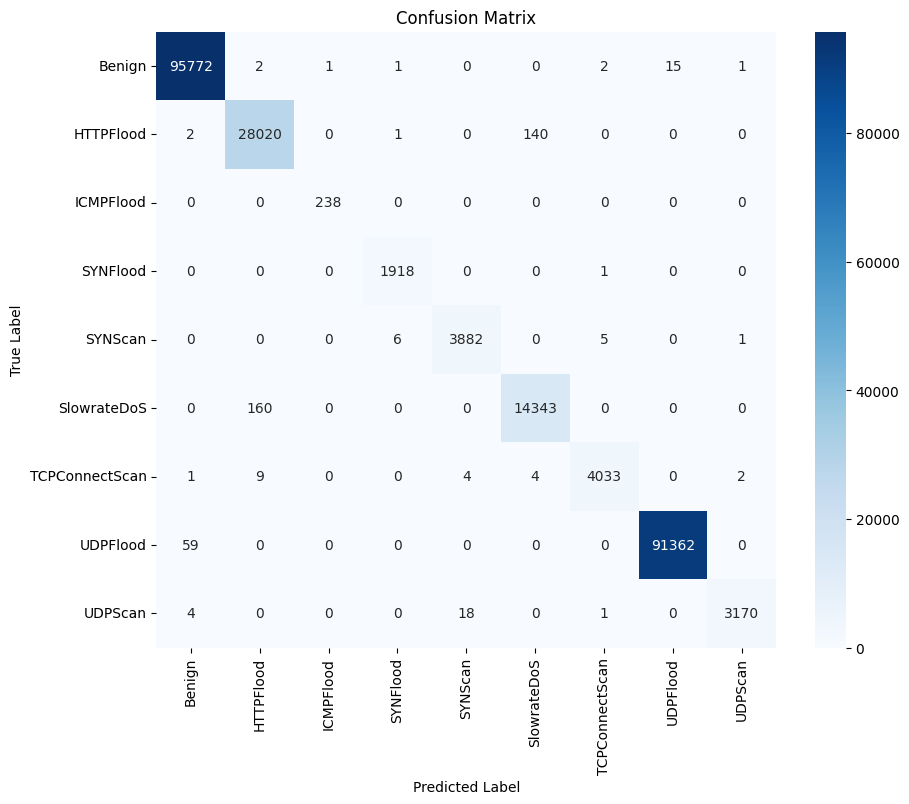

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()